In [37]:
import praw
import pandas as pd
import yaml
from textblob import TextBlob
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from dotenv import load_dotenv
import os
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pprint import pprint
import spacy
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

load_dotenv()

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Step 1: Load Data

def read_from_csv(topic, subreddit_name):
    filename = f'/mnt/d/knu/4cource/2/dm/lab1/data/2/reddit_{topic}_{subreddit_name}_posts.csv'
    try:
        df = pd.read_csv(filename)
        # print(f'Data loaded from {filename}')
        return df
    except FileNotFoundError:
        print(f'Error: {filename} not found.')
        return None

def load_multiple_topics(topics_subreddits):
    dfs = [read_from_csv(topic, subreddit) for topic, subreddits in topics_subreddits.items() for subreddit in subreddits]
    dfs = [df for df in dfs if df is not None]
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

# Step 2: Data Preprocessing

def clean_text(text):
    text = re.sub(r'\n+', ' ', text)  # Заміна нових рядків на пробіл
    text = re.sub(r'\s+', ' ', text)  # Заміна множинних пробілів на один
    text = re.sub(r'https\S+', '', text)  # Видалення URL
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)  # Видалення спецсимволів
    text = text.lower()  # Переведення в нижній регістр

    # Токенізація, лематизація та видалення стоп-слів
    doc = nlp(text)
    cleaned_words = [token.lemma_ for token in doc if not token.is_stop]
    # words = text.split()
    # cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(cleaned_words)

def preprocess_posts(df):
    df['title'] = df['title'].fillna('')
    df['text'] = df['text'].fillna('')
    df['cleaned_text'] = df['title'] + ' ' + df['text']
    df['cleaned_text'] = df['cleaned_text'].apply(clean_text)
    df['timestamp'] = pd.to_datetime(df['created'], unit='s', errors='coerce')
    return df

# Step 3: Sentiment Analysis

def analyze_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0.05:
        sentiment = 'Positive'
    elif analysis.sentiment.polarity < -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    
    return analysis.sentiment.polarity, sentiment
    
def add_sentiment(df):
    df[['polarity', 'sentiment']] = df['cleaned_text'].apply(lambda x: pd.Series(analyze_sentiment(x)))
    return df


def get_common_start_date(df):
    min_dates = df.groupby('topic')['timestamp'].min()
    common_start_date = min_dates.max()
    return common_start_date


# Step 4: Exploratory Data Analysis (EDA)

def plot_sentiment_distribution(df):
    plt.figure(figsize=(8, 5))
    plt.hist(df['sentiment'], bins=30, color='blue', edgecolor='black', alpha=0.7)
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

def wordcloud_by_sentiment(df, sentiment_label):
    sentiment_text = ' '.join(df[df['sentiment'] == sentiment_label]['cleaned_text'].astype(str))
    generate_wordcloud(sentiment_text, f'Word Cloud for {sentiment_label.capitalize()} Sentiment')

def plot_sentiment_distribution_by_topic(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='topic', y='polarity', palette='viridis')
    plt.title('Sentiment Distribution by Topic')
    plt.xlabel('Topic')
    plt.ylabel('Polarity')
    plt.xticks(rotation=45)
    plt.show()

def plot_average_sentiment_by_time(df, interval='M', start_date=None):
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

        if start_date is None:
            start_date = get_common_start_date(df)
        else:
            start_date = pd.to_datetime(start_date)

        df = df.loc[df['timestamp'] >= start_date].copy()

        df['period'] = df['timestamp'].dt.to_period(interval)

        avg_sentiment = df.groupby(['period', 'topic'])['polarity'].mean().unstack()
        avg_sentiment.plot(kind='line', figsize=(12, 7), marker='o')
        plt.title(f'Average Sentiment by Time ({interval})')
        plt.xlabel('Time Period')
        plt.ylabel('Average Polarity')
        plt.show()


In [39]:
def analyze_sentiment_across_topics():
    with open('configs/analyze1.yaml', 'r') as file:
        config = yaml.safe_load(file)
    topic_subreddits = config.get('topic_subreddits', {})

    df = load_multiple_topics(topic_subreddits)

    df = preprocess_posts(df)

    df = add_sentiment(df)

    return df 

df = analyze_sentiment_across_topics()

Data loaded from /mnt/d/knu/4cource/2/dm/lab1/data/2/reddit_news_news_posts.csv
Data loaded from /mnt/d/knu/4cource/2/dm/lab1/data/2/reddit_news_worldnews_posts.csv
Data loaded from /mnt/d/knu/4cource/2/dm/lab1/data/2/reddit_news_politics_posts.csv
Data loaded from /mnt/d/knu/4cource/2/dm/lab1/data/2/reddit_news_TrueReddit_posts.csv
Data loaded from /mnt/d/knu/4cource/2/dm/lab1/data/2/reddit_news_AskReddit_posts.csv
Data loaded from /mnt/d/knu/4cource/2/dm/lab1/data/2/reddit_news_todayilearned_posts.csv
Data loaded from /mnt/d/knu/4cource/2/dm/lab1/data/2/reddit_news_NoStupidQuestions_posts.csv
Data loaded from /mnt/d/knu/4cource/2/dm/lab1/data/2/reddit_news_CasualConversation_posts.csv
Data loaded from /mnt/d/knu/4cource/2/dm/lab1/data/2/reddit_news_PublicFreakout_posts.csv
Data loaded from /mnt/d/knu/4cource/2/dm/lab1/data/2/reddit_news_unpopularopinion_posts.csv
Data loaded from /mnt/d/knu/4cource/2/dm/lab1/data/2/reddit_science_science_posts.csv
Data loaded from /mnt/d/knu/4cource/

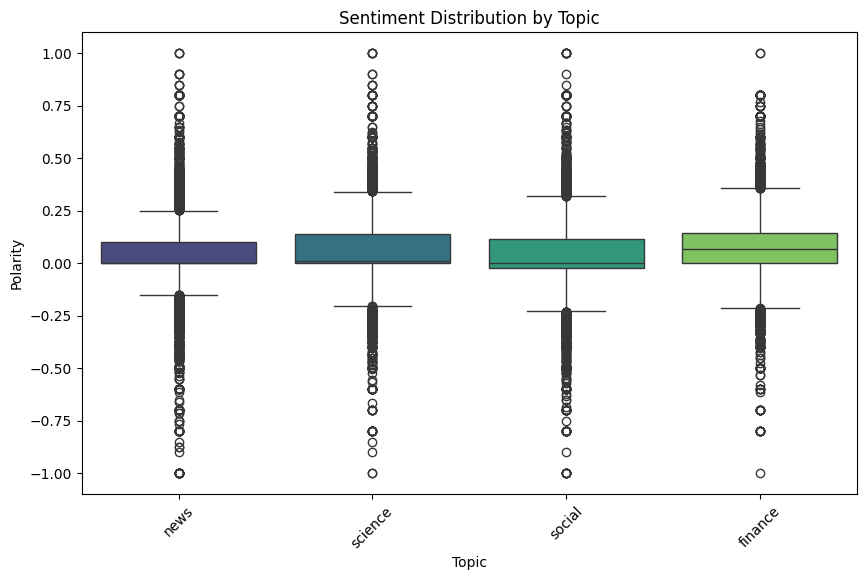

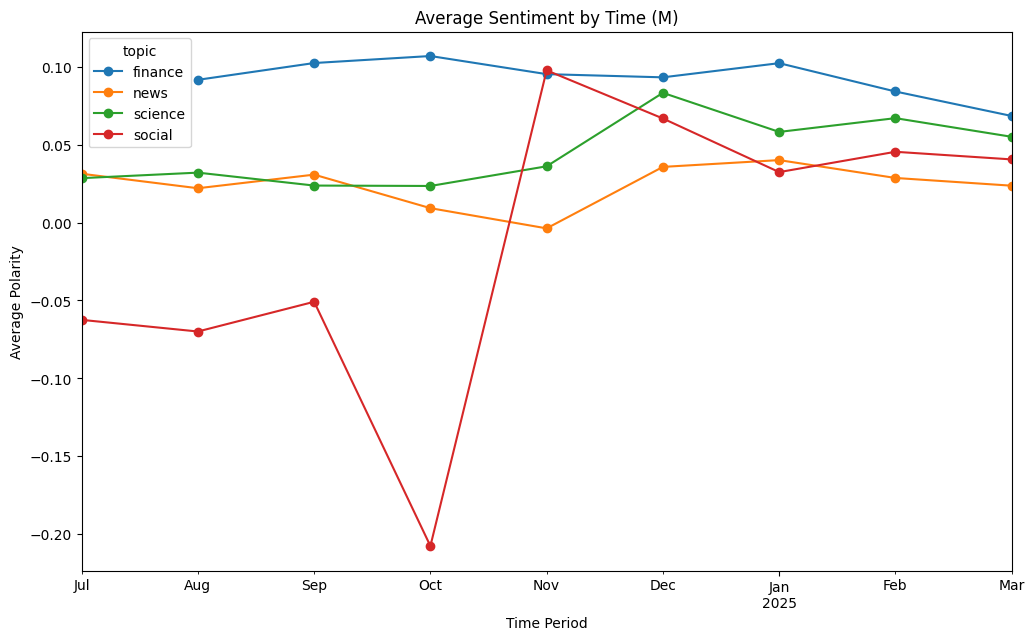

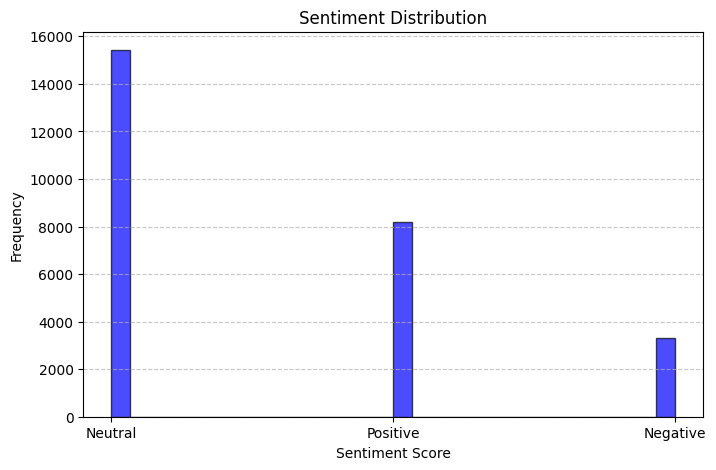

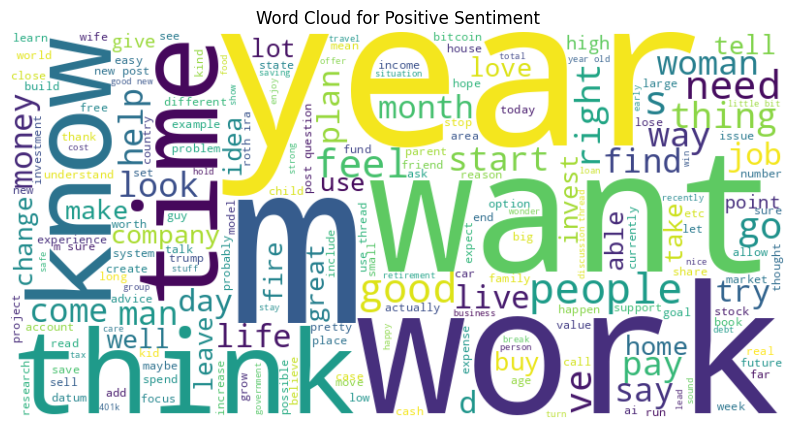

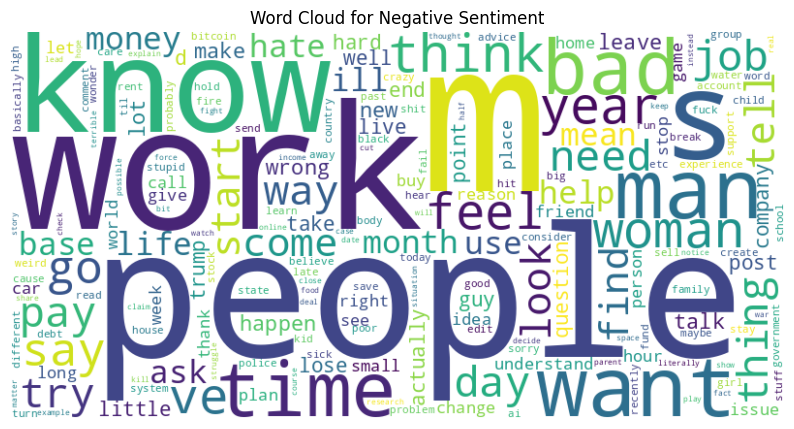

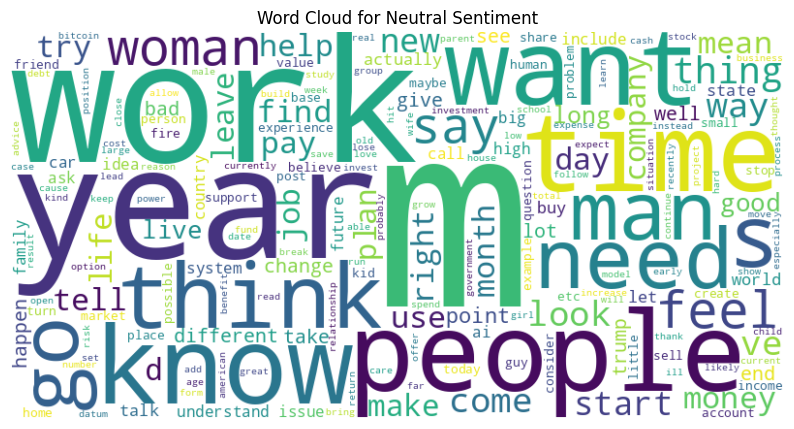

In [40]:
plot_sentiment_distribution_by_topic(df)

plot_average_sentiment_by_time(df, interval='M', start_date='2024-07-01')

plot_sentiment_distribution(df)

wordcloud_by_sentiment(df, 'Positive')
wordcloud_by_sentiment(df, 'Negative')
wordcloud_by_sentiment(df, 'Neutral')